In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [3]:
CUDA = torch.cuda.is_available()
device = torch.device("cuda" if CUDA else "cpu")
print(device)

cuda


In [ ]:
# 一開始的 Dense block 採用 Batch Normalization、ReLU、3x3 卷積層的結構
class basic_layer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(basic_layer, self).__init__()      
        self.basic = nn.Sequential(nn.BatchNorm2d(in_channels),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1, bias=False))

    def forward(self, x):
        out = self.basic(x)
        out = torch.cat([out, x], dim=1) 

        return out

In [4]:
# 為了降低通道維度、減少參數計算量，採用 Bottleneck (Batch Normalization、ReLU、1x1 卷積層、Batch Normalization、ReLU、3x3 卷積層)
class bottleneck_layer(nn.Module):
    def __init__(self, in_channels, bottleneck_size, growth_rate, drop_rate):
        super(bottleneck_layer, self).__init__()      
        self.bottleneck = nn.Sequential(nn.BatchNorm2d(in_channels),
                      nn.ReLU(inplace=True),
                      nn.Conv2d(in_channels=in_channels, out_channels=bottleneck_size*growth_rate, kernel_size=1, padding=0, bias=False),
                      nn.BatchNorm2d(bottleneck_size*growth_rate),
                      nn.ReLU(inplace=True),
                      nn.Conv2d(in_channels=bottleneck_size*growth_rate, out_channels=growth_rate, kernel_size=3, padding=1, bias=False))

        self.drop_rate = drop_rate
        self.dropout = nn.Dropout(p=self.drop_rate)

    def forward(self, x):
        out = self.bottleneck(x)
        if self.drop_rate > 0:
        out = self.dropout(out)

        out = torch.cat([out, x], dim=1) 

        return out

In [11]:
class DenseNet(nn.Module):
    def __init__(self, out_channels, growth_rate, num_layers, num_classes):
        super(DenseNet, self).__init__()      
        bottleneck_size = 4
        drop_rate = 0

        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=out_channels, kernel_size=7, stride=2, padding=3, bias=False),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU(inplace=True))

        self.maxpooling = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        layers = []
        block_in_channels = out_channels
        for i, num_layer in enumerate(num_layers):
        layers.append(self.dense_block(block_in_channels, bottleneck_size, growth_rate, drop_rate, num_layer))
        block_in_channels += num_layer*growth_rate

        if i != len(num_layers)-1:
          layers.append(self.transition_layer(block_in_channels, block_in_channels // 2))
          block_in_channels = block_in_channels // 2

        self.blocks = nn.Sequential(*layers)
        self.bn = nn.BatchNorm2d(block_in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.GAP_pooling = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(block_in_channels, num_classes)

    def dense_block(self, in_channels, bottleneck_size, growth_rate, drop_rate, num_layers):
        block = []
        for i in range(num_layers):
        block.append(bottleneck_layer(in_channels + i*growth_rate, bottleneck_size, growth_rate, drop_rate))

        return nn.Sequential(*block)

    def transition_layer(self, in_channels, out_channels):
        transition = nn.Sequential(nn.BatchNorm2d(in_channels),
                      nn.ReLU(inplace=True),
                      nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, padding=0, bias=False),
                      nn.AvgPool2d(kernel_size=2,stride=2))

        return transition

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpooling(x)
        x = self.blocks(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.GAP_pooling(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [22]:
def DenseNet_n(num_layers):
    if num_layers == 121:
        # DenseNet121
        model = DenseNet(64, 32, [6, 12, 24, 16], num_classes)

    elif num_layers == 169:
        # DenseNet169
        model = DenseNet(64, 32, [6, 12, 32, 32], num_classes)

    elif num_layers == 201:
        # DenseNet201
        model = DenseNet(64, 32, [6, 12, 48, 32], num_classes)

    elif num_layers == 101:
        # DenseNet
        model = DenseNet(64, 32, [6, 12, 64, 48], num_classes)

    else:
        print("error")

        return

    return model


In [23]:
# Parameters
batch_size = 64
num_epochs = 5
lr = 0.001

num_classes=2

# DenseNet121
# model = DenseNet(64, 32, [6, 12, 24, 16], num_classes)

# DenseNet169
model = DenseNet_n(169)

if CUDA:
    model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [13]:
import json
import zipfile
import os

# kaggle api
api_token = {"username":"aaa","key":"kkk"}
 
if not os.path.exists("/root/.kaggle"):
    os.makedirs("/root/.kaggle")

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json
 
if not os.path.exists("/kaggle"):
    os.makedirs("/kaggle")
os.chdir('/kaggle')
!kaggle datasets download -d chetankv/dogs-cats-images --force
 
!ls /kaggle

 98% 425M/435M [00:05<00:00, 62.5MB/s]
100% 435M/435M [00:06<00:00, 75.4MB/s]
dogs-cats-images.zip


In [14]:
!unzip dogs-cats-images.zip

串流輸出內容已截斷至最後 5000 行。
  inflating: dog vs cat/dataset/training_set/cats/cat.370.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3700.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3701.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3702.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3703.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3704.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3705.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3706.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3707.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3708.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3709.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.371.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3710.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3711.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3712.jpg  
  infl

In [24]:
# Transform
transform = transforms.Compose(
                [transforms.Resize(size=(227,227)),
                 transforms.CenterCrop(224),
                 transforms.RandomRotation(20),
                  transforms.RandomHorizontalFlip(),
                 transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),]
                )

# Data
train_dataset = datasets.ImageFolder(root='/kaggle/dataset/training_set', transform=transform)
valid_dataset = datasets.ImageFolder(root='/kaggle/dataset/test_set', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [16]:
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    total_train = 0
    correct_train = 0
    train_loss = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target) 
        
        if CUDA:
            data, target = data.cuda(), target.cuda()

        # clear gradient
        optimizer.zero_grad()

        # Forward propagation
        output = model(data) 
        loss = criterion(output, target) 

        # Calculate gradients
        loss.backward()

        # Update parameters
        optimizer.step()

        predicted = torch.max(output.data, 1)[1]
        total_train += len(target)
        correct_train += sum((predicted == target).float())
        train_loss += loss.item()

        if batch_idx % 100 == 0:
            print("Train Epoch: {}/{} [iter： {}/{}], acc： {:.6f}, loss： {:.6f}".format(
               epoch+1, num_epochs, batch_idx+1, len(train_loader),
               correct_train / float((batch_idx + 1) * batch_size),
               train_loss / float((batch_idx + 1) * batch_size)))
            
    train_acc_ = 100 * (correct_train / float(total_train))
    train_loss_ = train_loss / total_train
                    
    return train_acc_, train_loss_

In [17]:
def validate(valid_loader, model, criterion, epoch): 
    model.eval()
    total_valid = 0
    correct_valid = 0
    valid_loss = 0
    
    for batch_idx, (data, target) in enumerate(valid_loader):
        data, target = Variable(data), Variable(target) 
        
        if CUDA:
            data, target = data.cuda(), target.cuda()

        output = model(data)
        loss = criterion(output, target) 

        predicted = torch.max(output.data, 1)[1]
        total_valid += len(target)
        correct_valid += sum((predicted == target).float())
        valid_loss += loss.item()

        if batch_idx % 100 == 0:
            print("Valid Epoch: {}/{} [iter： {}/{}], acc： {:.6f}, loss： {:.6f}".format(
               epoch+1, num_epochs, batch_idx+1, len(valid_loader),
               correct_valid / float((batch_idx + 1) * batch_size),
               valid_loss / float((batch_idx + 1) * batch_size)))
            
    valid_acc_ = 100 * (correct_valid / float(total_valid))
    valid_loss_ = valid_loss / total_valid
                    
    return valid_acc_, valid_loss_

In [18]:
def training_loop(model, criterion, optimizer, train_loader, valid_loader):
    # set objects for storing metrics
    total_train_loss = []
    total_valid_loss = []
    total_train_accuracy = []
    total_valid_accuracy = []
 
    # Train model
    for epoch in range(num_epochs):
        # training
        train_acc_, train_loss_ = train(train_loader, model, criterion, optimizer, epoch)
        total_train_loss.append(train_loss_)
        total_train_accuracy.append(train_acc_)

        # validation
        with torch.no_grad():
            valid_acc_, valid_loss_ = validate(valid_loader, model, criterion, epoch)
            total_valid_loss.append(valid_loss_)
            total_valid_accuracy.append(valid_acc_)

        print('==========================================================================')
        print("Epoch: {}/{}， Train acc： {:.6f}， Train loss： {:.6f}， Valid acc： {:.6f}， Valid loss： {:.6f}".format(
               epoch+1, num_epochs, 
               train_acc_, train_loss_,
               valid_acc_, valid_loss_))
        print('==========================================================================')

    print("====== END ==========")

    return total_train_loss, total_valid_loss, total_train_accuracy, total_valid_accuracy

In [25]:
total_train_loss, total_valid_loss, total_train_accuracy, total_valid_accuracy = training_loop(model, criterion, optimizer, train_loader, valid_loader)

Train Epoch: 1/5 [iter： 1/125], acc： 0.531250, loss： 0.010726
Train Epoch: 1/5 [iter： 101/125], acc： 0.607828, loss： 0.010452
Valid Epoch: 1/5 [iter： 1/32], acc： 0.734375, loss： 0.008313
Epoch: 1/5， Train acc： 61.350006， Train loss： 0.010328， Valid acc： 66.950005， Valid loss： 0.010177
Train Epoch: 2/5 [iter： 1/125], acc： 0.593750, loss： 0.010825
Train Epoch: 2/5 [iter： 101/125], acc： 0.634901, loss： 0.010072
Valid Epoch: 2/5 [iter： 1/32], acc： 0.953125, loss： 0.004936
Epoch: 2/5， Train acc： 63.650002， Train loss： 0.010028， Valid acc： 58.549999， Valid loss： 0.011356
Train Epoch: 3/5 [iter： 1/125], acc： 0.781250, loss： 0.008216
Train Epoch: 3/5 [iter： 101/125], acc： 0.659499, loss： 0.009716
Valid Epoch: 3/5 [iter： 1/32], acc： 0.500000, loss： 0.012812
Epoch: 3/5， Train acc： 66.387505， Train loss： 0.009659， Valid acc： 63.600002， Valid loss： 0.010100
Train Epoch: 4/5 [iter： 1/125], acc： 0.546875, loss： 0.009870
Train Epoch: 4/5 [iter： 101/125], acc： 0.687964, loss： 0.009266
Valid Epoch: 4/5

In [27]:
def plot_result(total_train, total_valid, label):
    plt.plot(range(num_epochs), total_train, 'b-', label=f'Training_{label}')
    plt.plot(range(num_epochs), total_valid, 'g-', label=f'validation_{label}')
    plt.title(f'Training & Validation {label}')
    plt.xlabel('Number of epochs')
    plt.ylabel(f'{label}')
    plt.legend()
    plt.show()

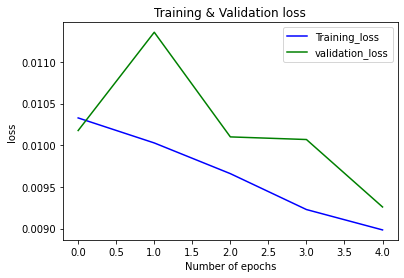

In [28]:
plot_result(total_train_loss, total_valid_loss, 'loss')

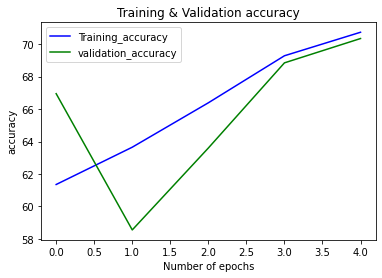

In [29]:
plot_result(total_train_accuracy, total_valid_accuracy, 'accuracy')